# Auto mpg dataset - predict mpg

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', \
         'acceleration', 'model_year', 'origin', 'car_name']
df = pd.read_table('auto.csv', delim_whitespace=True, names=names)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


In [3]:
# number of NaN's
len(df)-df.count()
# number or rows containing NaN's
len(df)-len(df.dropna())

14

In [4]:
# save rows with mpg NaN's for predicting; can test by simply looking up the values online
df_pred = df[df['mpg'].isnull()]
#df_pred.head(3)

In [5]:
# pop NaN's in horsepower and can 
df_hp_nans = df[df['horsepower'].isnull()]

In [6]:
# drop NaN's
df = df.dropna()
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


<a id = 'EDA'></a>
## Data Exploration and Visualization

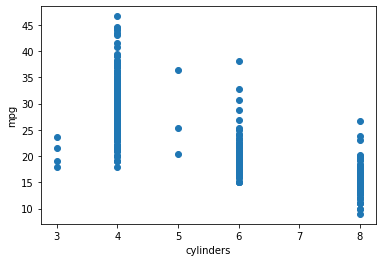

In [7]:
# see if cylinder is a good predictor
df['cylinders'].value_counts()
feature = 'cylinders'
response = 'mpg'

x = df[feature]
y = df[response]
plt.xlabel(feature);
plt.ylabel(response);
plt.scatter(x, y);

#### Maybe. Let's ignore 'cylinder' column for now.

In [8]:
# make a copy of df instead of overwriting it
col_kept = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']
df2 = df[col_kept].copy()
df2.head(8)

,mpg,displacement,horsepower,weight,acceleration
0,18.0,307.0,130.0,3504.0,12.0
1,15.0,350.0,165.0,3693.0,11.5
2,18.0,318.0,150.0,3436.0,11.0
3,16.0,304.0,150.0,3433.0,12.0
4,17.0,302.0,140.0,3449.0,10.5
5,15.0,429.0,198.0,4341.0,10.0
6,14.0,454.0,220.0,4354.0,9.0
7,14.0,440.0,215.0,4312.0,8.5


(array([33., 66., 83., 59., 60., 49., 31.,  5.,  6.]),
 array([ 9.        , 13.17777778, 17.35555556, 21.53333333, 25.71111111,
        29.88888889, 34.06666667, 38.24444444, 42.42222222, 46.6       ]),
 <a list of 9 Patch objects>)

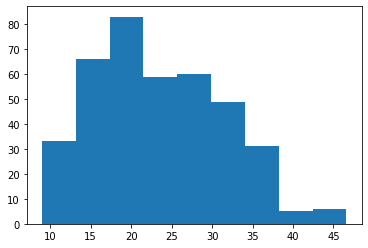

In [9]:
# check for skewness
plt.hist(df2['mpg'], bins=9)

#### Looks right-skewed. Perform Box-Cox transformation.

0.00013592593313660473

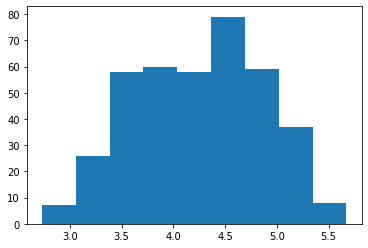

In [10]:
z = stats.boxcox(df2['mpg'])[0]
plt.hist(z, bins=9);
stats.boxcox(df2['mpg'])[1]
stats.shapiro(z)[1]

#### Looks pretty good despite low Shapiro-Wilk score.

# Make some plots to see how response depends on predictors

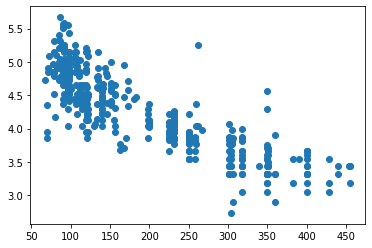

In [11]:
col = 'displacement'
#plt.scatter(df2[col], df2['mpg']);
plt.scatter(df2[col], z);

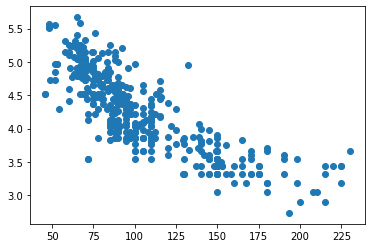

In [12]:
col = 'horsepower'
#plt.scatter(df2[col], df2['mpg']);
plt.scatter(df2[col], z);

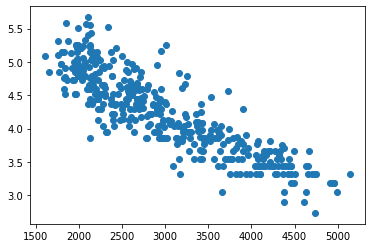

In [13]:
col = 'weight'
#plt.scatter(df2[col], df2['mpg']);
plt.scatter(df2[col], z);

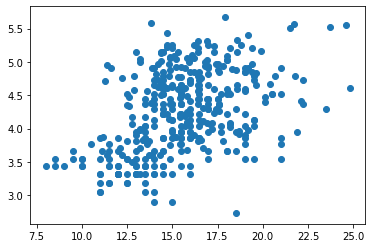

In [14]:
col = 'acceleration'
#plt.scatter(df2[col], df2['mpg']);
plt.scatter(df2[col], z);

#### The response seems to depend on inverse powers of 'displacement, horsepower, weight'

#### So, we can create new columns with their inverses and use these new columns with PolynomialFeatures

#### Acceleration doesn't look predictive; for a given x value, the y values span the range of y

In [15]:
# create 'inverse' columns and add transformed response column
for col in df2.columns[1:4]:
    df2.loc[:, 'inv_'+col] = 1. / df2.loc[:, col]
df2.loc[:, 'boxcox_mpg'] = z
df2.head(3)

,mpg,displacement,horsepower,weight,acceleration,inv_displacement,inv_horsepower,inv_weight,boxcox_mpg
0,18.0,307.0,130.0,3504.0,12.0,0.003257,0.007692,0.000285,3.859148
1,15.0,350.0,165.0,3693.0,11.5,0.002857,0.006061,0.000271,3.547736
2,18.0,318.0,150.0,3436.0,11.0,0.003145,0.006667,0.000291,3.859148


# Center and standardize columns

#### Split data into train/test sets and find mean/variance of train set for scaling

In [16]:
feature = ['inv_displacement', 'inv_horsepower', 'inv_weight']#, 'acceleration']
response = ['boxcox_mpg']#['mpg']

X_train, X_test, y_train, y_test = train_test_split(df2[feature], df2[response], test_size=0.15, random_state=10)

## Preparing Data for ML Algorithms

In [17]:
# obtain scalers and perform scaling, including the test sets
scalerX = preprocessing.StandardScaler().fit(X_train)
scalery = preprocessing.StandardScaler().fit(y_train)

X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)
y_train_scaled = scalery.transform(y_train)
y_test_scaled = scalery.transform(y_test)

# Construct regression model

In [18]:
# Use RidgeCV with PolynomialFeatures
alphas = np.logspace(0,2,10)
model = make_pipeline(preprocessing.PolynomialFeatures(3, interaction_only=True), \
                      RidgeCV(alphas=alphas))

In [19]:
# fit model and score it based on r^2
model.fit(X_train_scaled, y_train_scaled);
y_pred_scaled = model.predict(X_test_scaled)
model.score(X_test_scaled, y_test_scaled)

0.8238274746204534

#### Pretty good r^2

In [20]:
# Which predictors were important?
model.steps[0][1].get_feature_names(input_features=feature)
model.steps[1][1].coef_
#model.steps[1][1].intercept_

array([[ 0.        ,  0.13049645,  0.39530129,  0.50271534,  0.14788049,
        -0.05999678, -0.24261805, -0.05984646]])

### Make some plots to visualize accuracy of model predictions

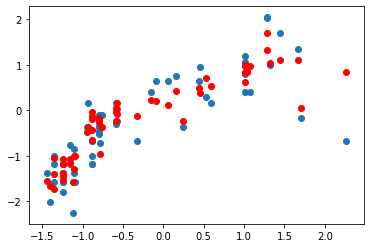

In [21]:
col = 0 # inv_displacement
plt.scatter(X_test_scaled[:, col], y_test_scaled);
plt.scatter(X_test_scaled[:, col], y_pred_scaled, c='r');

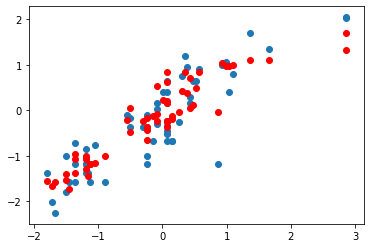

In [22]:
col = 1 # inv_horsepower
plt.scatter(X_test_scaled[:, col], y_test_scaled);
plt.scatter(X_test_scaled[:, col], y_pred_scaled, c='r');

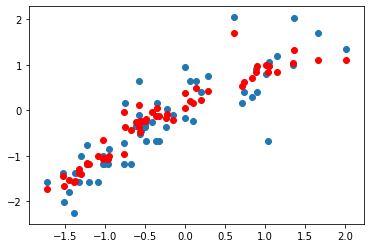

In [23]:
col = 2 # inv_weight
plt.scatter(X_test_scaled[:, col], y_test_scaled);
plt.scatter(X_test_scaled[:, col], y_pred_scaled, c='r');

#### Make a residual plot as a last check

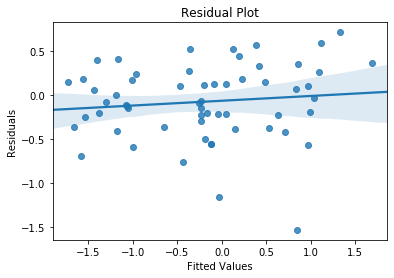

In [24]:
ax = sns.regplot(y_pred_scaled[:,0], y_test_scaled[:,0]-y_pred_scaled[:,0]);
ax.set(xlabel='Fitted Values', ylabel='Residuals', title='Residual Plot')
plt.show();

#### Not bad. It's dependent on the seed. Choosing fixed_state = 11 yields a flat line along zero.